# Exploring and unifying NAICS codes in the OSHA data
### Author: Jeff Minucci
### Date: 9/9/2019

In [126]:
%matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import datetime
from tabulate import tabulate
from numba import jit
%matplotlib inline

Using matplotlib backend: Qt5Agg


In [151]:
if not 'data/osha/osha_normalized.csv':
    with zipfile.ZipFile('data/osha/osha_normalized.zip','r') as zfile:
        zfile.extractall('data/osha')
osha = pd.read_csv('data/osha/osha_normalized.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ", "0","NaN", "nan", "NA", "na", "Na"])
osha = osha[osha.columns[1:]]
#osha['naics_code'] = osha['naics_code'].astype(int, errors = 'ignore')
#osha['sic_code'] = osha['sic_code'].astype(int, errors = 'ignore')

### Examining the NAICS codes reported in the osha data

#### How many workplaces have naics codes associated with them?

In [130]:
wp_naics = osha[['establishment_name', 'naics_code']].groupby(['establishment_name']).max()
percent_reported = len(wp_naics[wp_naics['naics_code'].astype(float)>1]) / len(wp_naics) * 100
print("Percent of workplaces with a naics code reported: {0:.0f}%".format(percent_reported))

Percent of workplaces with a naics code reported: 43%


In [152]:
osha['year'] = pd.DatetimeIndex(osha['date_sampled']).year

In [49]:
wp_naics_yr = osha[['establishment_name', 'naics_code','year']].groupby(['establishment_name', 'year']).max().reset_index()
print("Percent of workplaces with naics code reported by year:")
for yr in range(wp_naics_yr['year'].min(), wp_naics_yr['year'].max()+1):
    percent_reported = len(wp_naics_yr[(wp_naics_yr['year'] == yr) & (wp_naics_yr['naics_code']>1)])\
    / len(wp_naics_yr[wp_naics_yr['year'] == yr]) * 100
    print("{0}: {1:.0f}%".format(yr,percent_reported))

Percent of workplaces with naics code reported by year:
1984: 0%
1985: 0%
1986: 0%
1987: 0%
1988: 0%
1989: 0%
1990: 0%
1991: 1%
1992: 0%
1993: 0%
1994: 0%
1995: 0%
1996: 0%
1997: 1%
1998: 0%
1999: 1%
2000: 1%
2001: 2%
2002: 22%
2003: 98%
2004: 100%
2005: 100%
2006: 100%
2007: 100%
2008: 100%
2009: 100%
2010: 100%
2011: 100%
2012: 100%
2013: 100%
2014: 100%
2015: 100%
2016: 90%
2017: 100%
2018: 100%


#### How many workplaces have the older sic codes?

In [54]:
wp_sic = osha[['establishment_name', 'sic_code', 'naics_code']].groupby(['establishment_name']).max()
percent_reported = len(wp_sic[wp_sic['sic_code']>1]) / len(wp_sic) * 100
print("Percent of workplaces with an sic code reported: {0:.0f}%".format(percent_reported))

Percent of workplaces with an sic code reported: 82%


In [57]:
wp_sic_yr = osha[['establishment_name', 'naics_code', 'sic_code','year']].groupby(['establishment_name', 'year']).max().reset_index()
print("Percent of workplaces with sic code reported by year:")
for yr in range(wp_sic_yr['year'].min(), wp_sic_yr['year'].max()+1):
    percent_reported = len(wp_sic_yr[(wp_sic_yr['year'] == yr) & (wp_sic_yr['sic_code']>1)])\
    / len(wp_sic_yr[wp_sic_yr['year'] == yr]) * 100
    print("{0}: {1:.0f}%".format(yr,percent_reported))

Percent of workplaces with sic code reported by year:
1984: 100%
1985: 100%
1986: 100%
1987: 100%
1988: 100%
1989: 100%
1990: 100%
1991: 100%
1992: 100%
1993: 100%
1994: 100%
1995: 100%
1996: 100%
1997: 100%
1998: 100%
1999: 100%
2000: 100%
2001: 100%
2002: 100%
2003: 100%
2004: 100%
2005: 100%
2006: 100%
2007: 100%
2008: 100%
2009: 100%
2010: 100%
2011: 82%
2012: 25%
2013: 6%
2014: 4%
2015: 1%
2016: 10%
2017: 0%
2018: 0%


#### What format are the naics codes in? 
Options: 2002, 2007, 2012, 2017 <br>
2007 was the last major version, there are only a handful of changes in 2012 and 2017

In [59]:
wp_naics_yr[wp_naics_yr['year']==2003].head()

,establishment_name,year,naics_code
11,"104 WEST 40TH STREET PARTNERS, LLC",2003,561210.0
13,"110 GULF ASSOCIATES,",2003,531120.0
30,"18TH CENTURY HARDWARE COMPANY, INC.",2003,331528.0
41,21ST CENTURY PREPARATORY SCHOOL,2003,611110.0
57,3-D'S BRIDGE PAINTING CORP.,2003,237310.0


2003 data appears to be in 2007 or 2002 format. 331528 no longer exists in naics 2012 or 2017

In [79]:
wp_naics_yr[wp_naics_yr['naics_code']==211130].head()

,establishment_name,year,naics_code


No data appears to be in 2017 naics format

#### Convert sic codes to naics codes when naics codes aren't available

Many sic codes map to more than one possible naics code

In [ ]:
sic_naics_2002 = pd.read_csv('data/naics/1987_SIC_to_2002_NAICS.csv', 
                            dtype={'SIC': str, '2002 NAICS': str},
                             na_values = ["", " ", "0", "AUX", "Aux", "NaN", "nan"])
sic_naics_2002_one2one = sic_naics_2002.drop_duplicates(subset=['SIC']) #make one to one, keeping first mapping of NAICS
len(sic_naics_2002), len(sic_naics_2002_one2one)

In [185]:
thresholds = range(1,230)
counts = []
code_counts = sic_naics_2002.SIC.value_counts()
for x in thresholds:
    counts.append(len(code_counts[code_counts == x]))
print(tabulate({'Num of occurrences':thresholds, 'Num of substances':counts}, headers = 'keys', tablefmt='psql'))

+----------------------+---------------------+
|   Num of occurrences |   Num of substances |
|----------------------+---------------------|
|                    1 |                 551 |
|                    2 |                 185 |
|                    3 |                 103 |
|                    4 |                  81 |
|                    5 |                  34 |
|                    6 |                  17 |
|                    7 |                  12 |
|                    8 |                   5 |
|                    9 |                   5 |
|                   10 |                   4 |
|                   11 |                   1 |
|                   12 |                   2 |
|                   13 |                   0 |
|                   14 |                   1 |
|                   15 |                   0 |
|                   16 |                   0 |
|                   17 |                   0 |
|                   18 |                   1 |
|            

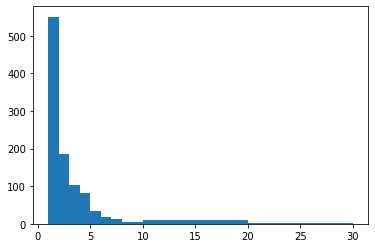

In [187]:
code_counts.hist(grid=False,bins = [1,2,3,4,5,6,7,8,9,10,20,30] )
plt.show()

In [166]:
sic_naics_2002 = pd.read_csv('data/naics/1987_SIC_to_2002_NAICS.csv', 
                            dtype={'SIC': str, '2002 NAICS': str},
                             na_values = ["", " ", "0", "AUX", "Aux", "NaN", "nan"])
#sic_naics_2002['SIC'] = sic_naics_2002['SIC'].astype(int) 
naics_missing = np.where(osha['naics_code'].astype(float) > 1000,0,1)
sic = osha['sic_code'].astype(int, errors='ignore').astype(str)
naics_from_sic = pd.DataFrame(sic).merge(sic_naics_2002[['SIC', '2002 NAICS']].dropna(), left_on='sic_code',
                         right_on='SIC', how='left')
naics_from_sic
#naics_from_sic = naics_from_sic.groupby(['SIC'])['2002 NAICS'].first().reset_index()

,sic_code,SIC,2002 NAICS
0,3365,3365,331524
1,3365,3365,331524
2,3365,3365,331524
3,3365,3365,331524
4,3612,3612,335311
...,...,...,...
3400166,nan,NaN,NaN
3400167,nan,NaN,NaN
3400168,nan,NaN,NaN
3400169,nan,NaN,NaN


In [174]:
sic_naics_2002 = pd.read_csv('data/naics/1987_SIC_to_2002_NAICS.csv', 
                            dtype={'SIC': str, '2002 NAICS': str},
                             na_values = ["", " ", "0", "AUX", "Aux", "NaN", "nan"])
sic_naics_2002 = sic_naics_2002.drop_duplicates(subset=['SIC']) #make one to one, keeping first mapping of NAICS
#sic_naics_2002['SIC'] = sic_naics_2002['SIC'].astype(int) 
osha_merged = osha.merge(sic_naics_2002[['SIC', '2002 NAICS']].dropna(), left_on='sic_code',
                         right_on='SIC', how='left')
naics_missing = np.where(osha_merged['naics_code'].astype(float) > 1000,0,1)
osha_merged['naics_unified'] = np.where(naics_missing, osha_merged['2002 NAICS'], osha_merged['naics_code'])
#sic = osha['sic_code'].astype(int, errors='ignore').astype(str)
#naics_from_sic = pd.DataFrame(sic).merge(sic_naics_2002[['SIC', '2002 NAICS']].dropna(), left_on='sic_code',
#                         right_on='SIC', how='left')
#osha_merged = osha_merged.drop_duplicates(subset=['inspection_number, 'establishment_name', ])
#naics_from_sic = naics_from_sic.groupby(['SIC'])['2002 NAICS'].first().reset_index()

In [178]:
sic_naics_2002 = pd.read_csv('data/naics/1987_SIC_to_2002_NAICS.csv', 
                            dtype={'SIC': str, '2002 NAICS': str},
                             na_values = ["", " ", "0", "AUX", "Aux", "NaN", "nan"])
sic_naics_2002_one2one = sic_naics_2002.drop_duplicates(subset=['SIC']) #make one to one, keeping first mapping of NAICS
len(sic_naics_2002), len(sic_naics_2002_one2one)

(2168, 1005)

In [175]:
len(osha_merged), len(osha)

(1309640, 1309640)

In [177]:
osha_merged

,inspection_number,establishment_name,city,state,zip_code,sic_code,naics_code,sampling_number,office_id,date_sampled,...,unit_of_measurement,qualifier,input,average_mass,preferred_name,conc_mgm3,year,SIC,2002 NAICS,naics_unified
0,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365,NaN,5.24554e+06,214700.0,1984/05/07 00:00:00,...,M,NaN,Thorium,232.0377,Thorium,0.000500,1984,3365,331524,331524
1,111211,CONTROLLED CASTINGS CORP,Plainview,NY,11803.0,3365,NaN,5.2455e+06,214700.0,1984/05/07 00:00:00,...,M,NaN,Thorium,232.0377,Thorium,0.016000,1984,3365,331524,331524
2,111252,MID ISLAND NON FERROUS FOUNDRY,East Farmingdale,NY,11735.0,3365,NaN,5.24534e+06,214700.0,1984/04/04 00:00:00,...,M,NaN,"Lead, Inorganic (as Pb)",207.2000,Lead,0.064000,1984,3365,331524,331524
3,111252,MID ISLAND NON FERROUS FOUNDRY,East Farmingdale,NY,11735.0,3365,NaN,5.24534e+06,214700.0,1984/04/04 00:00:00,...,M,BLK,"Lead, Inorganic (as Pb)",207.2000,Lead,NaN,1984,3365,331524,331524
4,114645,TRILECTRON INDUSTRIES INC,Hawthorne,NJ,7506.0,3612,NaN,5.26995e+06,214500.0,1984/04/16 00:00:00,...,M,ND,"Lead, Inorganic (as Pb)",207.2000,Lead,NaN,1984,3612,335311,335311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309635,1319671,VUTEC MANAGEMENT CORP.,CORAL SPRINGS,FL,33065.0,NaN,423990,321855,418800.0,2018-AUG-02,...,M,<=,Iron Oxide Dust and Fume (as Fe203) Total Part...,NaN,Iron oxide,2.129000,2018,NaN,NaN,423990
1309636,1319671,VUTEC MANAGEMENT CORP.,CORAL SPRINGS,FL,33065.0,NaN,423990,321857,418800.0,2018-AUG-02,...,M,<=,Iron Oxide Dust and Fume (as Fe203) Total Part...,NaN,Iron oxide,0.302000,2018,NaN,NaN,423990
1309637,1319671,VUTEC MANAGEMENT CORP.,CORAL SPRINGS,FL,33065.0,NaN,423990,321857,418800.0,2018-AUG-02,...,M,<=,Iron Oxide Dust and Fume (as Fe203) Total Part...,NaN,Iron oxide,0.102000,2018,NaN,NaN,423990
1309638,1319671,VUTEC MANAGEMENT CORP.,CORAL SPRINGS,FL,33065.0,NaN,423990,321857,418800.0,2018-AUG-02,...,M,ND-BLK,Iron Oxide Dust and Fume (as Fe203) Total Part...,NaN,Iron oxide,NaN,2018,NaN,NaN,423990


In [154]:
sic_naics_2002[['SIC', '2002 NAICS']].dropna()

,SIC,2002 NAICS
0,0111,111140
1,0112,111160
2,0115,111150
3,0116,111110
4,0119,111120
...,...,...
2159,9641,926140
2160,9651,926150
2161,9661,927110
2162,9711,928110


In [160]:
len(sic)

1309640

In [165]:
len(naics_from_sic)

889

In [162]:
naics_from_sic.tail()

,sic_code,establishment_name,SIC,2002 NAICS
3400166,nan,VUTEC MANAGEMENT CORP.,NaN,NaN
3400167,nan,VUTEC MANAGEMENT CORP.,NaN,NaN
3400168,nan,VUTEC MANAGEMENT CORP.,NaN,NaN
3400169,nan,VUTEC MANAGEMENT CORP.,NaN,NaN
3400170,nan,"McCorvey Sheet Metal Works, L.P.",NaN,NaN


In [148]:
len(naics_from_sic[naics_from_sic['2002 NAICS'] == "NaN"])

0